#서울시 고립은둔청년 분류모델 개발
2팀 : 강승주, 김진성, 박학진, 이슬기



---


###프로젝트 배경
 - 집에서 ‘쉬었음’이라고 응답한 청년 숫자가 증가
 - 코로나 19를 거치면서 사회적 관계 안전망 부족에 대한 우려


---


###프로젝트 목표
고립은둔청년과 관련된 공공 데이터를 수집 및 분석하여
고립은둔 여부와 유형*을 판단하는 분류 모델을 개발


---



In [1]:
# 1. 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.utils import resample

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import to_categorical

In [3]:
# 딥러닝 모델용 인스톨
!pip install tensorflow
!pip install pandas
!pip install scikit-learn
!pip install matplotlib

In [4]:
# 모든 열과 행 표시
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
# Excel 파일 경로 지정 (파일 경로는 본인의 드라이브 구조에 맞춰 수정하세요)
file_path = '/content/drive/MyDrive/프로젝트/★DATA_서울시 고립은둔청년 실태조사(청년조사)_v1_230127.xlsx'

# Excel 파일을 DataFrame으로 읽기
df = pd.read_excel(file_path)

# # 데이터 출력
# df.head()

In [6]:
# df.info()

#1.전처리



Merge

In [7]:
# Merge할 Excel 파일 경로 지정 (파일 경로는 본인의 드라이브 구조에 맞춰 수정하세요)
merge_data_file_path = '/content/drive/MyDrive/프로젝트/a_2023.1월_10개 관심집단 수.xlsx'

df_merge = pd.read_excel(merge_data_file_path)

# df_merge.head()

In [8]:
# 자치구 번호 매핑
gu_mapping = {
    "강남구": 1, "강동구": 2, "강북구": 3, "강서구": 4, "관악구": 5, "광진구": 6, "구로구": 7, "금천구": 8,
    "노원구": 9, "도봉구": 10, "동대문구": 11, "동작구": 12, "마포구": 13, "서대문구": 14, "서초구": 15,
    "성동구": 16, "성북구": 17, "송파구": 18, "양천구": 19, "영등포구": 20, "용산구": 21, "은평구": 22,
    "종로구": 23, "중구": 24, "중랑구": 25
}

df_merge['자치구'] = df_merge['자치구'].replace(gu_mapping)

df_merge = df_merge[df_merge['연령대'] < 40]

df_merge = df_merge.rename(columns={
    '자치구': 'SQ4',
    '성별': 'SQ1',
    '연령대': 'SQ2',
})

# 19~39세 5살 간격으로 Grouping
def age_grouping(age):
    if 19 <= age <= 24:
        return 1  # 만 19~24세
    elif 25 <= age <= 29:
        return 2  # 만 25~29세
    elif 30 <= age <= 34:
        return 3  # 만 30~34세
    elif 35 <= age <= 39:
        return 4  # 만 35~39세
    else:
        return None  # 범위 밖의 나이는 None 처리

df_merge['SQ2_X'] = df_merge['SQ2'].apply(age_grouping)

# print(df_merge)

<ipython-input-8-846b6ae3a79a>:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_merge['자치구'] = df_merge['자치구'].replace(gu_mapping)


In [9]:
# Merge할 Key 칼럼 설정
merged_df = df_merge.groupby(['SQ4', 'SQ1', 'SQ2_X']).sum().reset_index()

# print(merged_df)

In [10]:
# Sub 데이터셋 전처리 후 새로운 엑셀 파일 출력
merged_df.to_excel('processed_data.xlsx', index=False)

save_dir = '/content/drive/MyDrive/프로젝트'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

merged_df.to_excel(os.path.join(save_dir, 'processed_data.xlsx'), index=False)

In [11]:
# 전처리한 Sub 데이터셋과 기본 데이터셋을 Merge
merged_file_path = '/content/drive/MyDrive/프로젝트/processed_data.xlsx'

df1 = pd.read_excel(file_path)
df2 = pd.read_excel(merged_file_path)

df_right = pd.merge(df1, df2, on=['SQ4', 'SQ1', 'SQ2_X'], how='right')

# print(df_right.head())

In [12]:
# Merge한 데이터셋을 출력
df_right.to_excel('processed_mergedata.xlsx', index=False)

save_dir = '/content/drive/MyDrive/프로젝트'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

df_right.to_excel(os.path.join(save_dir, 'processed_mergedata.xlsx'), index=False)

▶Save Point

In [13]:
# 출력한 데이터셋을 가져오기
merged_file_path = '/content/drive/MyDrive/프로젝트/processed_mergedata.xlsx'

df = pd.read_excel(merged_file_path)
# df.head()

##EDA

In [14]:
#EDA 이후 필요없는 Columns Drop(Seq, seoul, grade, Text 등)
df.drop(columns=['SEQ',
                 'KEY_1',
                 'SQ2_R','SQ3','SQ6',
                 'SQ7_12_ETC_1','SQ8_12_ETC_1',
                 'A2_1_9_ETC_1','A4_8_ETC_1','A16_11_ETC_1','A17_1_5_ETC_1',
                 'B2','B5_8_ETC_1','B6_5_ETC_1','B7_7_ETC_1','C2_7_ETC_1',
                 'C4_9_ETC_1','C5x9','C6x9','C7x9','C8_1_11_ETC_1',
                 'C8_4_8_ETC_1','C8_6_8_ETC_1','C9','DQ2_9_ETC_1','DQ5_7_ETC_1',
                 '행정동코드','행정동명'],
        inplace=True)
# df.info()

In [15]:
# df.head()

In [16]:
# Sub 데이터셋 컬럼명 변경
new_column_names = [f'M{i}' for i in range(1, 13)]
df.columns.values[-12:] = new_column_names
df.head()

,QCL_3,SQ1,SQ2_x,SQ2_X,SQ4,SQ5,SQ6_R,SQ7_1,SQ7_2,SQ7_3,SQ7_4,SQ7_5,SQ7_6,SQ7_7,SQ7_8,SQ7_9,SQ7_10,SQ7_11,SQ7_12,SQ8_1,SQ8_2,SQ8_3,SQ8_4,SQ8_5,SQ8_6,SQ8_7,SQ8_8,SQ8_9,SQ8_10,SQ8_12,SQ8_13,A1,A2,A2_1_1,A2_1_2,A2_1_3,A2_1_4,A2_1_5,A2_1_6,A2_1_7,A2_1_8,A2_1_9,A3,A4_1,A4_2,A4_3,A4_4,A4_5,A4_6,A4_7,A4_8,A5,A6,A7,A8,A9,A9_1,A10,A11,A12_1_1,A12_1_2,A12_1_3,A12_1_4,A12_2_1,A12_2_2,A12_2_3,A12_2_4,A12_3_1,A12_3_2,A12_3_3,A12_3_4,A12_4_1,A12_4_2,A12_4_3,A12_4_4,A13_1,A13_2,A13_3,A13_4,A14,A15,A15_1,A16_1,A16_2,A16_3,A16_4,A16_5,A16_6,A16_7,A16_8,A16_9,A16_10,A16_11,A17,A17_1_1,A17_1_2,A17_1_3,A17_1_4,A17_1_5,A18_1,A18_2,A18_3,A18_4,A19_1,A19_2,A19_3,A19_4,A19_5,A19_6,A20_1,A20_2,A20_3,A20_4,A20_5,A20_6,A20_7,A20_8,B1_1,B1_2,B1_3,B1_4,B1_5,B2_R,B3,B4,B5_1,B5_2,B5_3,B6_1,B6_2,B6_3,B6_4,B6_5,B6_6,B7,B8,B9_1,B9_2,B9_3,B9_4,B10,B11,B11_1,B12_1,B12_2,B12_3,B12_4,B12_5,B12_6,B12_7,B12_8,B12_9,RB12_1,RB12_2,RB12_3,RB12_4,RB12_5,RB12_6,RB12_7,RB12_8,RB12_9,RB12,C1,C1_1,C2,C3,C4_1,C4_2,C4_3,C4_4,C4_5,C4_6,C4_7,C4_8,C4_9,C5x1,C5x2,C5x3,C5x4,C5x5,C5x6,C5x7,C5x8,C6x1,C6x2,C6x3,C6x4,C6x5,C6x6,C6x7,C6x8,C7x1,C7x2,C7x3,C7x4,C7x5,C7x6,C7x7,C7x8,C8,C8_1,C8_2,C8_3,C8_4_1,C8_4_2,C8_4_3,C8_4_4,C8_4_5,C8_4_6,C8_4_7,C8_4_8,C8_5,C8_6_1,C8_6_2,C8_6_3,C8_6_4,C8_6_5,C8_6_6,C8_6_7,C8_6_8,DQ1,DQ2,DQ3,DQ5,DQ5_1,DQ6,SQ2_y,M1,M2,M3,M4,M5,M6,M7,M8,M9,M10,M11,M12
0,NaN,1,22,1,1,2.0,4,1.0,2.0,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,3.0,3.0,5,2.0,1,22.0,3.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,3.0,NaN,5,4,4,5,NaN,1,22.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,2.0,NaN,NaN,NaN,3,3,2,3,2,2,1,2,2,1,2,2,1,2,2,1,2,2,3,4,4,4,3,2.0,2.0,2.0,2,3.0,5.0,NaN,2.0,3.0,NaN,NaN,NaN,2,4,3,3,4,4,4,2,NaN,3,4,2,3,3,3,2,3,2,2,3,1,2,2,2,1,2,1,16,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,8.0,2.0,4,1.0,2,440,17228.0,3059.5,380.32,264.07,292.34,284.32,213.12,389.33,330.35,259.58,259.07,226.45
1,NaN,1,23,1,1,1.0,4,1.0,2.0,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,6.0,NaN,NaN,4.0,4.0,1,NaN,2,NaN,30.0,10.0,1.0,2.0,3.0,NaN,1.0,2.0,3.0,NaN,1.0,2.0,3.0,NaN,1.0,2.0,3.0,NaN,6,6,6,6,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,2.0,3.0,4.0,NaN,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,4,4,5,2.0,2.0,3.0,3,2.0,1.0,1.0,2.0,3.0,4.0,NaN,NaN,2,3,5,5,5,5,4,2,NaN,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,1.0,2.0,4,1.0,1,440,17228.0,3059.5,380.32,264.07,292.34,284.32,213.12,389.33,330.35,259.58,259.07,226.45
2,NaN,1,22,1,1,3.0,3,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,3,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,3.0,3.0,6,6.0,1,20.0,0.0,0.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.0,4,3,3,4,4.0,2,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,2,2,3,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,3,3,2,3.0,3.0,3.0,1,2.0,3.0,NaN,NaN,3.0,NaN,NaN,NaN,3,4,2,2,3,3,3,2,NaN,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,9,2.0,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,9,8.0,2.0,3,2.0,2,440,17228.0,3059.5,380.32,264.07,292.34,284.32,213.12,389.33,330.35,259.58,259.07,226.45
3,NaN,1,22,1,1,1.0,4,1.0,2.0,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [17]:
# Merge한 데이터셋을 출력
df.to_excel('processed_mergedata.xlsx', index=False)

save_dir = '/content/drive/MyDrive/프로젝트'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

df.to_excel(os.path.join(save_dir, 'processed_mergedata.xlsx'), index=False)

### Save Point

In [18]:
# 출력한 데이터셋을 가져오기
merged_file_path = '/content/drive/MyDrive/프로젝트/processed_mergedata.xlsx'

df = pd.read_excel(merged_file_path)
# df.head()

###1.1 결측치 처리

In [19]:
#EDA 이후 '-1' 로 결측치 처리해야 할 Columns의 결측치 확인
df[['A10', 'A11', 'A15_1']].isna().sum()

,0
A10,159
A11,159
A15_1,3250


In [20]:
#해당 Columns '-1' 로 결측치 처리
df[['A10', 'A11', 'A15_1']] = df[['A10', 'A11', 'A15_1']].fillna(-1)

#처리 결과 확인
df[['A10', 'A11', 'A15_1']].isna().sum()

,0
A10,0
A11,0
A15_1,0


In [21]:
#나머지 결측치 확인
df.isna().sum().head(15)

,0
QCL_3,5027
SQ1,0
SQ2_x,0
SQ2_X,0
SQ4,0
SQ5,80
SQ6_R,0
SQ7_1,3139
SQ7_2,2754
SQ7_3,5454


In [22]:
# 결측치를 '0' 으로 처리
df = df.fillna(0)

# 처리결과 확인
df.isna().sum().head(15)

,0
QCL_3,0
SQ1,0
SQ2_x,0
SQ2_X,0
SQ4,0
SQ5,0
SQ6_R,0
SQ7_1,0
SQ7_2,0
SQ7_3,0


In [23]:
#0과 1로 변경할 Colums명 배열 정의
bool_columns = ['SQ7_1','SQ7_2','SQ7_3','SQ7_4','SQ7_5','SQ7_6','SQ7_7','SQ7_8','SQ7_9','SQ7_10','SQ7_11','SQ7_12',
                'SQ8_1','SQ8_2','SQ8_3','SQ8_4','SQ8_5','SQ8_6','SQ8_7','SQ8_8','SQ8_9','SQ8_10','SQ8_12','SQ8_13',
                'A4_1','A4_2','A4_3','A4_4','A4_5','A4_6','A4_7','A4_8',
                'A16_1','A16_2','A16_3','A16_4','A16_5','A16_6','A16_7','A16_8','A16_9','A16_10','A16_11',
                'A17_1_1','A17_1_2','A17_1_3','A17_1_4','A17_1_5',
                'B6_1', 'B6_2', 'B6_3', 'B6_4', 'B6_5', 'B6_6',
                'RB12_1','RB12_2','RB12_3','RB12_4','RB12_5','RB12_6','RB12_7','RB12_8','RB12_9',
                'C4_1', 'C4_2', 'C4_3', 'C4_4', 'C4_5', 'C4_6', 'C4_7', 'C4_8', 'C4_9',
                'C8_4_1', 'C8_4_2', 'C8_4_3', 'C8_4_4', 'C8_4_5', 'C8_4_6', 'C8_4_7', 'C8_4_8',
                'C8_6_1', 'C8_6_2', 'C8_6_3', 'C8_6_4', 'C8_6_5', 'C8_6_6', 'C8_6_7', 'C8_6_8',
                ]

In [24]:
# True False 원 & 핫 인코딩된 데이터 1로 바꾸기
df[bool_columns] = df[bool_columns].applymap(lambda x: 1 if x > 0 else x)

# #처리결과 확인
# df[bool_columns].head()

<ipython-input-24-b662f9f95f2e>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[bool_columns] = df[bool_columns].applymap(lambda x: 1 if x > 0 else x)


###1.2 이상치 처리

In [25]:
#이상치 요약 함수 정의
def detect_outliers(df):
    outliers_summary = {}

    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

        outliers_summary[column] = {
            'Lower Bound': lower_bound,
            'Upper Bound': upper_bound,
            'Outlier Count': outliers.shape[0],
            'Outlier Values': outliers[column].values
        }

    return outliers_summary

# 이상치 요약 출력
outliers_summary = detect_outliers(df)
for column, summary in outliers_summary.items():
  if summary['Outlier Count'] != 0:
    print(f"Column: {column}")
    print(f"  Lower Bound: {summary['Lower Bound']}")
    print(f"  Upper Bound: {summary['Upper Bound']}")
    print(f"  Outlier Count: {summary['Outlier Count']}")
    print(f"  Outlier Values: {summary['Outlier Values']}\n")

Column: QCL_3
  Lower Bound: 0.0
  Upper Bound: 0.0
  Outlier Count: 486
  Outlier Values: [2. 2. 1. 2. 1. 3. 3. 2. 3. 2. 2. 3. 3. 4. 3. 2. 1. 1. 1. 2. 1. 1. 2. 2.
 4. 3. 2. 4. 3. 2. 1. 1. 2. 2. 3. 4. 3. 4. 3. 4. 3. 3. 2. 1. 1. 2. 2. 2.
 2. 1. 1. 2. 3. 3. 4. 3. 1. 3. 4. 2. 1. 2. 2. 2. 4. 3. 1. 2. 1. 1. 2. 1.
 2. 1. 2. 2. 1. 2. 3. 2. 4. 4. 3. 2. 1. 2. 1. 2. 1. 1. 1. 2. 2. 3. 2. 3.
 1. 3. 4. 4. 2. 2. 1. 4. 2. 4. 4. 3. 3. 3. 3. 1. 2. 1. 1. 2. 2. 1. 3. 2.
 3. 4. 2. 1. 1. 1. 2. 1. 3. 4. 4. 4. 4. 4. 3. 4. 3. 1. 2. 2. 2. 1. 2. 3.
 3. 2. 4. 3. 4. 4. 3. 4. 3. 4. 3. 3. 3. 2. 1. 2. 2. 1. 2. 2. 3. 4. 4. 3.
 4. 2. 1. 4. 4. 4. 4. 2. 1. 1. 2. 3. 2. 1. 2. 2. 1. 2. 3. 3. 3. 2. 2. 1.
 1. 2. 4. 1. 4. 4. 4. 1. 2. 2. 2. 2. 2. 2. 3. 3. 2. 1. 4. 4. 3. 3. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 4. 4. 4. 4. 4. 4. 3. 4. 3. 3. 4. 3. 2. 2. 1. 2.
 2. 2. 2. 2. 2. 3. 3. 4. 3. 1. 1. 2. 4. 1. 2. 3. 3. 3. 1. 1. 2. 1. 1. 3.
 3. 3. 3. 1. 1. 2. 2. 3. 3. 3. 3. 4. 4. 3. 1. 1. 1. 1. 1. 4. 2. 3. 3. 3.
 4. 3. 4. 4. 3. 4. 2. 2. 4. 4. 2.

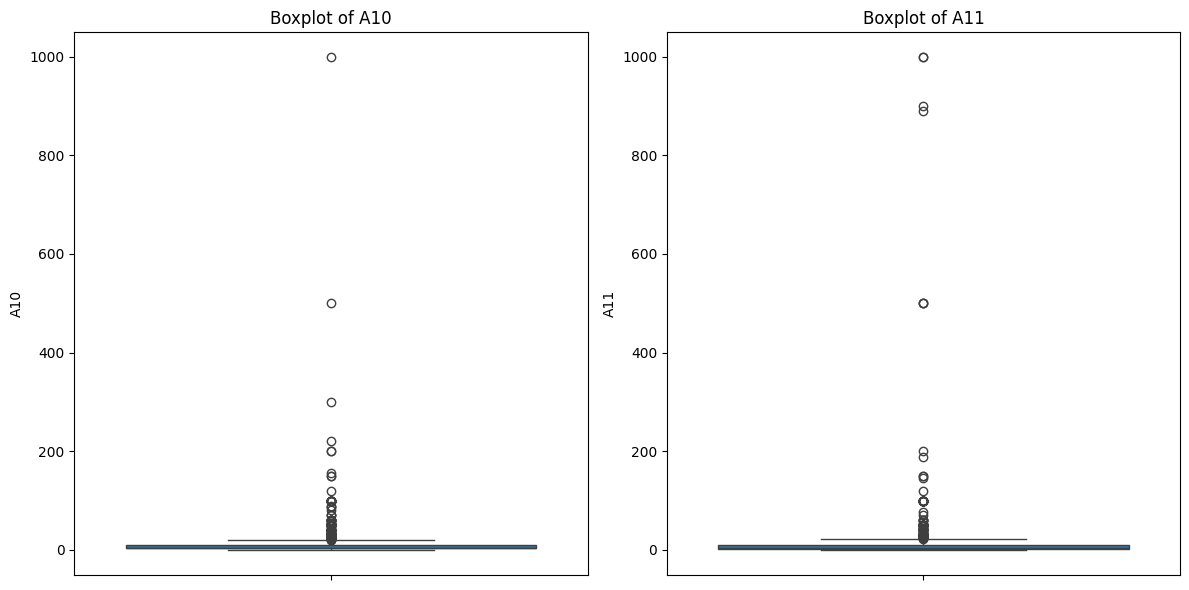

In [26]:
# A10, A11 컬럼에 대한 boxplot 생성
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(y=df['A10'])
plt.title('Boxplot of A10')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['A11'])
plt.title('Boxplot of A11')

plt.tight_layout()
plt.show()

In [27]:
#이상치 삭제 전 QCL_3 Value Counts
df['QCL_3'].value_counts()

,count
QCL_3,
0.0,5027
2.0,160
4.0,111
3.0,110
1.0,105


In [28]:
# A10, A11 (사람과 만남 수) 의 값이 30 초과인 데이터 행 삭제
df = df[(df['A10'] <= 30) & (df['A11'] <= 30)]

#삭제 후 QCL_3 Value Counts
df['QCL_3'].value_counts()

,count
QCL_3,
0.0,4835
2.0,160
3.0,110
4.0,110
1.0,105


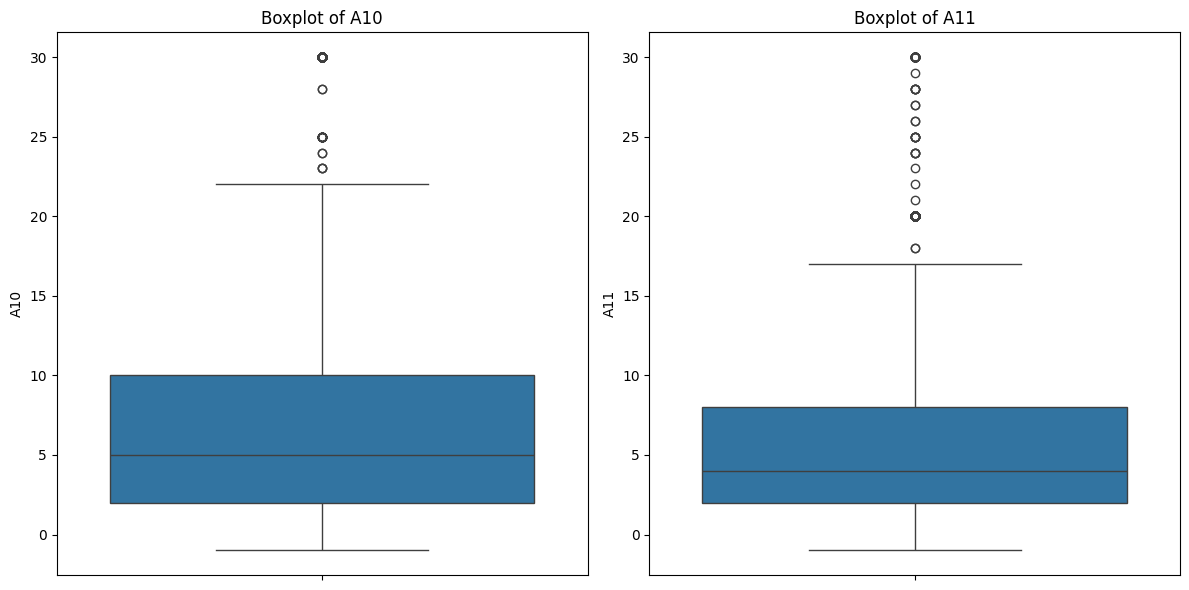

In [29]:
# 이상치 처리 후 A10, A11 컬럼에 대한 boxplot 생성
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(y=df['A10'])
plt.title('Boxplot of A10')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['A11'])
plt.title('Boxplot of A11')

plt.tight_layout()
plt.show()

###1.3 샘플링(Under)

In [30]:
# 다수 클래스와 소수 클래스 분리
df_majority = df[df['QCL_3'] == 0]
df_minority = df[df['QCL_3'] > 0]

# 소수 클래스를 다수 클래스 수에 맞춰 오버샘플링
df_minority_oversampled = resample(df_minority,
                                   replace=True,    # 복원 추출 여부 (오버샘플링을 위해 True)
                                   # n_samples=len(df_majority),  # 다수 클래스 수에 맞춤
                                   n_samples=len(df_majority)*4,  # 다수 클래스 수의 평균에 맞추거나 원하는 수 설정
                                   random_state=42)  # 재현성을 위한 랜덤 시드

# 오버샘플링된 데이터프레임 결합
df = pd.concat([df_majority, df_minority_oversampled])

# 최종 클래스 분포 확인
print("\n오버샘플링 후 클래스 분포:")
df['QCL_3'].value_counts()


오버샘플링 후 클래스 분포:


,count
QCL_3,
2.0,6340
0.0,4835
4.0,4441
3.0,4405
1.0,4154


In [31]:
# 다수 클래스와 소수 클래스 분리
df_key = df[df['QCL_3'] == 0]
df_majority = df[df['QCL_3'] == 2]
df_minority = df[df['QCL_3'] != 2]

# 다수 클래스 샘플을 소수 클래스 수에 맞춰 언더샘플링
df_majority_downsampled = resample(df_majority,
                                    replace=False,    # 복원 추출 여부
                                    # n_samples=len(df_minority),  # 소수 클래스 수에 맞춤
                                    n_samples=len(df_key),  # 소수 클래스 수의 평균에
                                    random_state=42)  # 재현성을 위한 랜덤 시드

# 언더샘플링된 데이터프레임 결합
df = pd.concat([df_majority_downsampled, df_minority])

# 최종 클래스 분포 확인
print("\n언더샘플링 후 클래스 분포:")
df['QCL_3'].value_counts()


언더샘플링 후 클래스 분포:


,count
QCL_3,
2.0,4835
0.0,4835
4.0,4441
3.0,4405
1.0,4154


In [32]:
# Save point
df.to_csv('/content/drive/MyDrive/Colab Notebooks/이기언_강사님_자료/csv_files/df_downsampled.csv', index=False)

▶Save Point

In [33]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/이기언_강사님_자료/csv_files/df_downsampled.csv')
df['QCL_3'].value_counts()

,count
QCL_3,
2.0,4835
0.0,4835
4.0,4441
3.0,4405
1.0,4154


###1.4 특성 선택 및 시각화
correlation matrix



In [34]:
# # 특징과 타겟 나누기
# X = df.drop(columns=['QCL_3'])
# y = df['QCL_3']

In [35]:
# 스케일러 생성
scaler = StandardScaler()

# 데이터 표준화 (fit_transform은 학습과 변환을 동시에 진행)
scaled_data = scaler.fit_transform(df)

# 결과를 데이터프레임으로 다시 변환 (원래 컬럼명 유지)
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)

print(scaled_df.head())

      QCL_3       SQ1     SQ2_x     SQ2_X       SQ4       SQ5     SQ6_R  \
0  0.016693 -1.050595 -0.346042 -0.718220  0.035429  2.003203 -1.364487   
1  0.016693 -1.050595 -1.138044 -0.718220  1.145760 -0.605892  0.224873   
2  0.016693  0.951842 -0.940044 -0.718220  1.145760  2.003203  0.224873   
3  0.016693  0.951842 -1.534045 -1.713942 -1.074901 -0.605892  0.224873   
4  0.016693 -1.050595 -1.732045 -1.713942  1.423343 -0.605892  0.224873   

      SQ7_1     SQ7_2     SQ7_3     SQ7_4     SQ7_5    SQ7_6     SQ7_7  \
0 -0.913395 -1.119789 -0.113833 -0.149407 -0.333252 -0.79816 -0.028189   
1  1.094816  0.893025 -0.113833 -0.149407 -0.333252 -0.79816 -0.028189   
2  1.094816  0.893025 -0.113833 -0.149407 -0.333252 -0.79816 -0.028189   
3  1.094816  0.893025 -0.113833 -0.149407 -0.333252 -0.79816 -0.028189   
4  1.094816  0.893025 -0.113833 -0.149407 -0.333252 -0.79816 -0.028189   

      SQ7_8     SQ7_9    SQ7_10    SQ7_11    SQ7_12     SQ8_1     SQ8_2  \
0 -0.263611 -0.047948 -0.0704

In [36]:
# 상관 행렬 계산
corr = scaled_df.corr()

In [37]:
# 상관 행렬에서 'QCL_3'와의 상관 계수를 선택하고 전치
filtered_corr = corr[['QCL_3']].T

# 0.3 이상의 값만 필터링
# filtered_corr = filtered_corr[filtered_corr.abs() >= 0.3]

# 0.3 이상의 값을 가진 컬럼만 선택
# filtered_corr = filtered_corr.loc[:, filtered_corr.iloc[0].abs() >= 0.3]

filtered_corr = filtered_corr[['QCL_3','SQ2_x','A10','B12_6','RB12','C1']]

filtered_corr

,QCL_3,SQ2_x,A10,B12_6,RB12,C1
QCL_3,1.0,0.445572,-0.217331,0.015927,-0.0362,0.444569


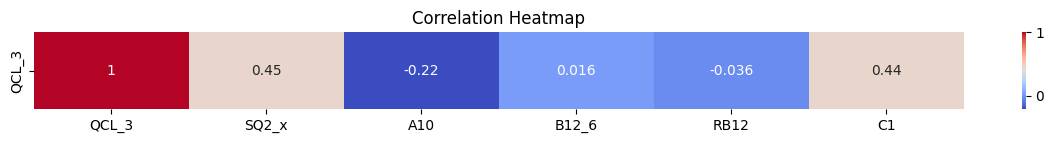

In [38]:
# 히트맵 그리기
plt.figure(figsize=(15, 1))
sns.heatmap(filtered_corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

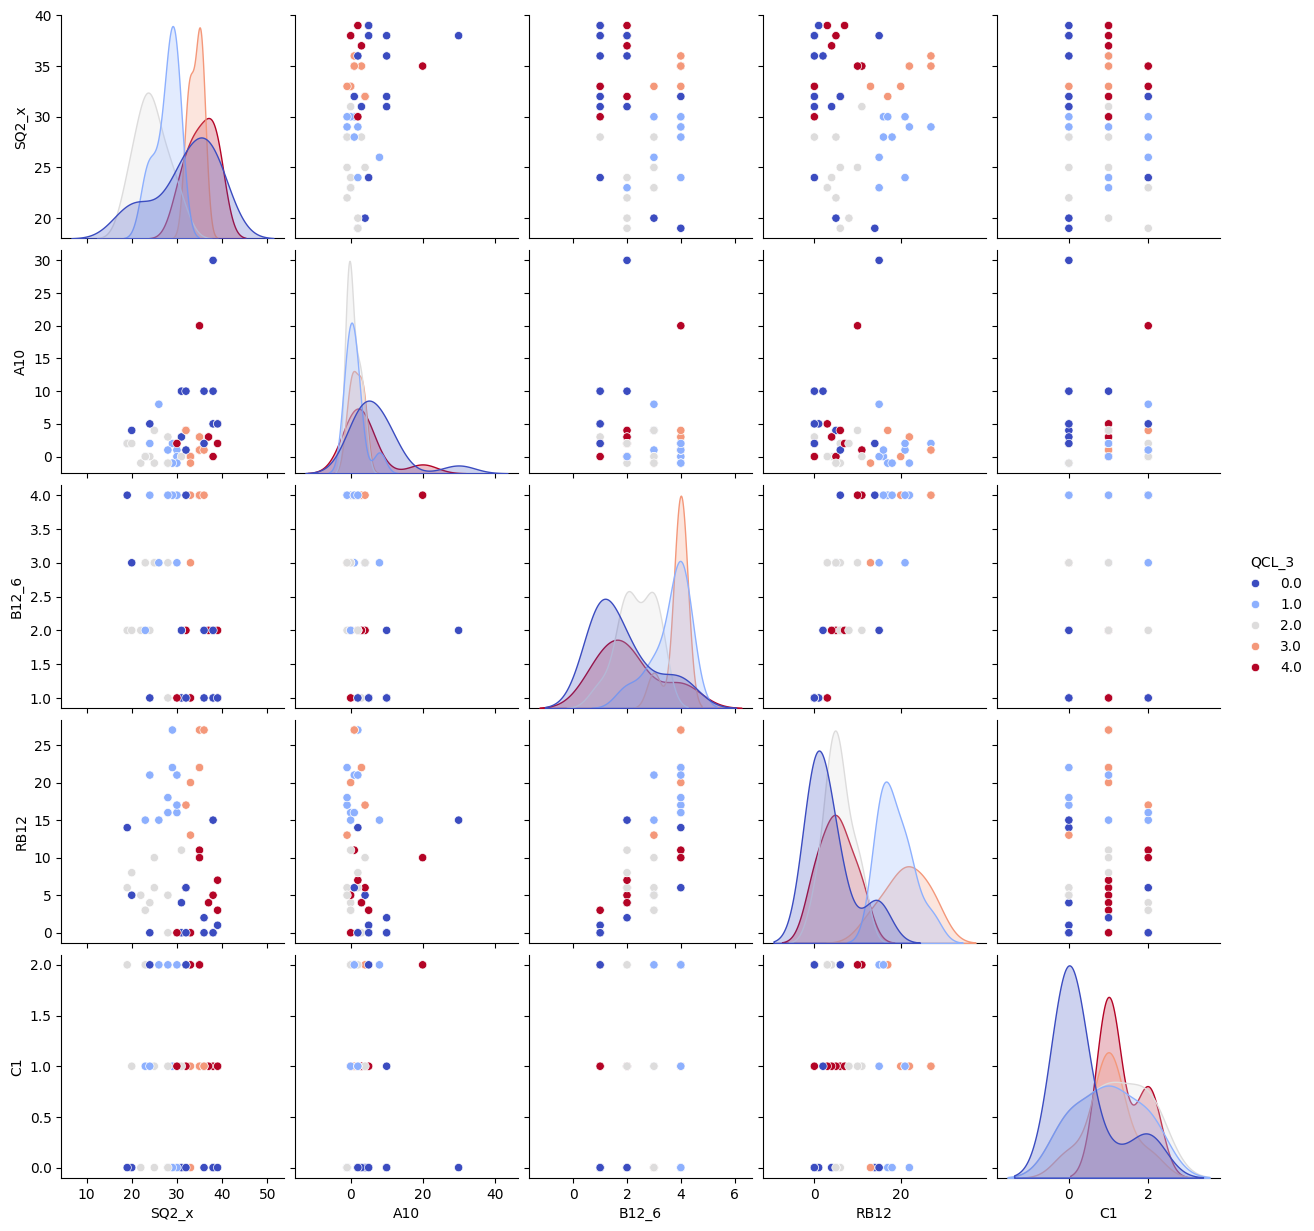

In [39]:
# pair plot
sample_df = df[filtered_corr.columns].sample(n=50)  # 50개 샘플 선택
sns.pairplot(sample_df, hue='QCL_3', palette='coolwarm')

# 그래프 보여주기
plt.show()

Lasso, RandomForest, LogisticRegression 를 활용한 특성 추출

In [40]:
# 특징과 타켓 나누기
X_scaled = scaled_df.drop(columns=['QCL_3'])
y = df['QCL_3']

# # 데이터 분할
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

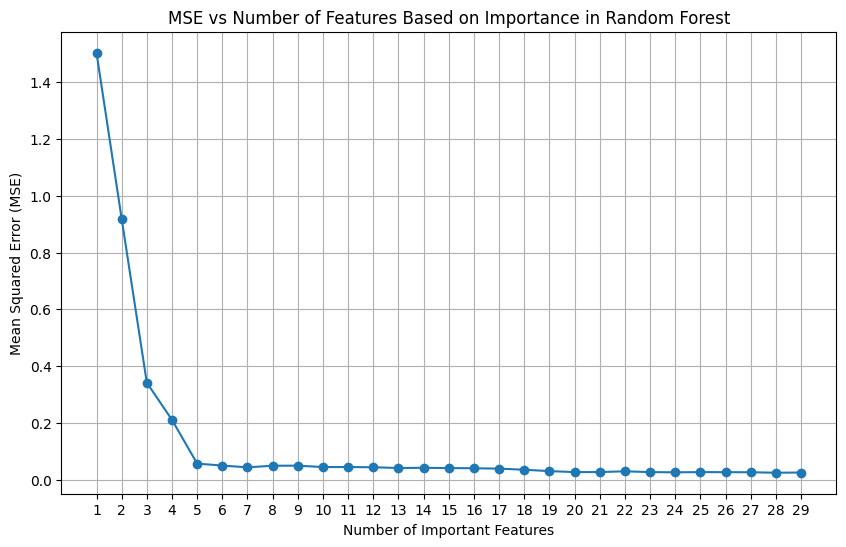

In [41]:
# 모델 훈련에 필요한 칼럼 수 알기

# 랜덤 포레스트 모델 학습
model = RandomForestRegressor(random_state=42)
model.fit(X_scaled, y)

# 특성 중요도 계산
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]  # 중요도에 따라 내림차순 정렬

# 성능 지표를 저장할 리스트
mse_scores = []

# 중요도에 따른 특성 수에 따른 성능 평가
for n_features in range(1, 30):
    X_subset = X_scaled.iloc[:, indices[:n_features]]  # 중요도가 높은 첫 n_features 개 컬럼 선택
    X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(range(1, 30), mse_scores, marker='o')
plt.title('MSE vs Number of Features Based on Importance in Random Forest')
plt.xlabel('Number of Important Features')
plt.ylabel('Mean Squared Error (MSE)')
plt.xticks(range(1, 30))
plt.grid()
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [45]:
# 랜덤 포레스트 모델 훈련
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# 칼럼 중요도 확인
importances = rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X_scaled.columns, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 파악된 모델 훈련에 필요한 칼럼 수(5개)로 중요 칼럼명 배열 생성
import_columns = importance_df.head(5)['Feature'].values
import_columns

array(['SQ2_x', 'SQ2_X', 'RB12', 'A14', 'B12_1'], dtype=object)

In [47]:
# 로지스틱 회귀 모델 훈련
model = LogisticRegression()
model.fit(X_train, y_train)

# 피처 중요도 (계수) 확인
importance = model.coef_[0]
features = X_scaled.columns  # X가 데이터프레임인 경우
importance_df = pd.DataFrame({'Feature': features, 'Coefficient': importance})

# 절대값 기준으로 정렬
importance_df['Abs_Coefficient'] = importance_df['Coefficient'].abs()
importance_df = importance_df.sort_values(by='Abs_Coefficient', ascending=False)

importance_df.head(5)

,Feature,Coefficient,Abs_Coefficient
78,A14,-5.231168,5.231168
41,A3,-2.600270,2.600270
221,DQ3,1.814672,1.814672
84,A16_4,-1.696428,1.696428
81,A16_1,-1.505167,1.505167


##1.5 Data 분할 및 스케일링

In [54]:
# EDA로 선별한 5개 컬럼
X_scaled = scaled_df[['SQ2_x','A10','B12_6','RB12','C1']]
y = df['QCL_3']

In [49]:
# # 랜덤 포레스트 선정 5개 컬럼
# X_scaled = scaled_df[import_columns]
# y = df['QCL_3']

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18, random_state=42)

#2. 모델 훈련

In [56]:
# 1. SVM 분류
# SVC(Support Vector Classifier, 초평면을 사용하여 데이터 분류
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_pred = svm_clf.predict(X_val)
train_pred = svm_clf.predict(X_train)

print("SVM Accuracy(train):", accuracy_score(y_train, train_pred))
print("SVM Accuracy(val):", accuracy_score(y_val, svm_pred))

# 1. SVM 분류 TEST Set
svm_pred = svm_clf.predict(X_test)

print("SVM Accuracy(test):", accuracy_score(y_test, svm_pred))

SVM Accuracy(train): 0.963987341772152
SVM Accuracy(val): 0.9633900259440761
SVM Accuracy(test): 0.9597177300793884


In [57]:
# 2. KNN 분류
# K-최근접 이웃(KNN) 알고리즘
knn_clf = KNeighborsClassifier(n_neighbors=3) # n_neighbors=3 : 가까운 3개의 이웃을 참조, 분류 수행
knn_clf.fit(X_train, y_train)
knn_pred = knn_clf.predict(X_val)
train_pred = knn_clf.predict(X_train)

print("k-NN Accuracy(train):", accuracy_score(y_train, train_pred))
print("k-NN Accuracy(val):", accuracy_score(y_val, knn_pred))

# 2. KNN 분류 TEST Set
knn_pred = knn_clf.predict(X_test)

print("k-NN Accuracy(test):", accuracy_score(y_test, knn_pred))

k-NN Accuracy(train): 0.9866455696202532
k-NN Accuracy(val): 0.9818391467281637
k-NN Accuracy(test): 0.9805939429579535


In [58]:
# 3. Decision Tree 분류
# 트리 구조를 사용하여 데이터 분기, 트리의 끝에서 최종 클래스 예측
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_val)
train_pred = dt_clf.predict(X_train)

print("Decision Tree Accuracy(train):", accuracy_score(y_train, train_pred))
print("Decision Tree Accuracy(val):", accuracy_score(y_val, dt_pred))

# 3. Decision Tree 분류 Test Set
dt_pred = dt_clf.predict(X_test)

print("Decision Tree Accuracy(test):", accuracy_score(y_test, dt_pred))

Decision Tree Accuracy(train): 0.9980379746835443
Decision Tree Accuracy(val): 0.9855866243874315
Decision Tree Accuracy(test): 0.9894148779770656


In [59]:
# 4. Random Forest 분류
# 여러 개의 결정 트리로 구성된 앙상블 모델
rf_clf = RandomForestClassifier(n_estimators=500, random_state=42) # 500개의 결정 트리 사용
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_val)
train_pred = rf_clf.predict(X_train)

print("Random Forest Accuracy(train):", accuracy_score(y_train, train_pred))
print("Random Forest Accuracy:", accuracy_score(y_val, rf_pred))

# 4. Random Forest 분류 Test Set
rf_pred = rf_clf.predict(X_test)

print("Random Forest Accuracy(test):", accuracy_score(y_test, rf_pred))

Random Forest Accuracy(train): 0.9980379746835443
Random Forest Accuracy: 0.9841452868261746
Random Forest Accuracy(test): 0.9858865039694208


###3. 하이퍼 파라미터 튜닝

In [60]:
# 랜덤 포레스트 모델 생성
rf = RandomForestClassifier(random_state=42)

# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# 그리드 서치 실행
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           scoring='accuracy', cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)

# 결과 출력
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"최고의 하이퍼파라미터: {best_params}")
print(f"최고의 교차 검증 점수: {best_score:.4f}")

최고의 하이퍼파라미터: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
최고의 교차 검증 점수: 0.9856


###4. K Fold 검정

In [61]:
# K-Fold 교차 검증 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 교차 검증을 통한 모델 훈련 및 평가
model = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42)

# Data Split
X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=42)

# K-Fold 교차 검증
for fold, (train_index, val_index) in enumerate(kf.split(X_train_val)):
    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]

    model.fit(X_train, y_train)  # 모델 훈련
    y_val_pred = model.predict(X_val)  # 검증 세트 예측
    accuracy = accuracy_score(y_val, y_val_pred)  # 정확도 평가

    y_train_pred = model.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    print(f'Fold {fold + 1}, Train Accuracy: {train_acc:.4f}')
    print(f'Fold {fold + 1}, Validation Accuracy: {accuracy:.4f}')


# 최종 테스트 세트 평가
y_test_pred = model.predict(X_test)  # 테스트 세트 예측
final_accuracy = accuracy_score(y_test, y_test_pred)  # 최종 정확도 평가
print(f'Final Test Accuracy: {final_accuracy:.4f}')

Fold 1, Train Accuracy: 0.9980
Fold 1, Validation Accuracy: 0.9842
Fold 2, Train Accuracy: 0.9982
Fold 2, Validation Accuracy: 0.9886
Fold 3, Train Accuracy: 0.9980
Fold 3, Validation Accuracy: 0.9860
Fold 4, Train Accuracy: 0.9979
Fold 4, Validation Accuracy: 0.9868
Fold 5, Train Accuracy: 0.9976
Fold 5, Validation Accuracy: 0.9894
Final Test Accuracy: 0.9871


### 딥러닝 모델

In [62]:
# 1. 타겟 변수 `y`의 원-핫 인코딩
num_classes = len(np.unique(y))  # 클래스 수 확인
y_categorical = to_categorical(y, num_classes=num_classes)

# 2. Train-test split (원-핫 인코딩 된 `y`를 사용)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_categorical, test_size=0.2, random_state=42)

# 3. 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. 모델 설계
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))

# 5. 출력 레이어 수정 (클래스 수에 맞춰 설정)
model.add(Dense(num_classes, activation='softmax'))  # Multi-class classification

# 6. 학습률 스케줄링 함수 정의
def lr_schedule(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 10
    return initial_lr * (drop ** (epoch // epochs_drop))

# 7. 콜백 설정 (조기 종료, 학습률 스케줄링)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = LearningRateScheduler(lr_schedule)

# 8. 모델 컴파일 (다중 분류 문제를 위한 categorical_crossentropy 사용)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 9. 모델 학습
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stopping, lr_scheduler]
)

# 10. 모델 평가
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
567/567 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.8125 - loss: 0.5191 - val_accuracy: 0.9385 - val_loss: 0.2082 - learning_rate: 0.0010
Epoch 2/100
567/567 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9096 - loss: 0.2754 - val_accuracy: 0.9552 - val_loss: 0.1642 - learning_rate: 0.0010
Epoch 3/100
567/567 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9253 - loss: 0.2332 - val_accuracy: 0.9517 - val_loss: 0.1591 - learning_rate: 0.0010
Epoch 4/100
567/567 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9344 - loss: 0.2176 - val_accuracy: 0.9649 - val_loss: 0.1400 - learning_rate: 0.0010
Epoch 5/100
567/567 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9441 - loss: 0.1828 - val_accuracy: 0.9579 - val_loss: 0.1496 - learning_rate: 0.0010
Epoch 6/100
567/567 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9452 - loss: 0.1789 - val_accuracy: 0.9654 - val_loss: 0.1316 - learning_rate: 0.0010
Epoch 7/100
567/567 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9455 - loss: 

In [63]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 132,113 (516.07 KB)

 Trainable params: 43,781 (171.02 KB)

 Non-trainable params: 768 (3.00 KB)

 Optimizer params: 87,564 (342.05 KB)